Vettore delle features (1000 elementi):
[-7.85868824e-01  5.07411838e-01 -1.14176238e+00  4.88379389e-01
 -1.78083992e+00  1.18950117e+00 -1.02474129e+00 -2.28448415e+00
 -2.69636679e+00 -2.10753965e+00 -1.08665931e+00 -3.02269244e+00
 -2.76973844e-01 -2.58168244e+00 -5.41605890e-01 -2.57497692e+00
 -5.80288839e+00 -2.74823284e+00 -3.14790702e+00 -1.20365667e+00
 -4.06453180e+00 -3.28168249e+00 -3.82785702e+00 -2.95966434e+00
 -9.75157499e-01 -1.66422188e+00 -1.80501306e+00 -5.38847029e-01
 -2.23118141e-01 -1.20048416e+00 -1.68771505e-01 -9.00945365e-02
 -1.25801489e-02  6.67218864e-01  1.12958992e+00  2.13531852e+00
  2.97020411e+00  1.47964132e+00 -2.85517663e-01 -2.55952883e+00
 -1.78402221e+00 -1.77693629e+00 -3.84063387e+00 -6.50913835e-01
 -1.66514707e+00 -1.60825288e+00 -2.63458586e+00 -1.98804528e-01
 -2.15112495e+00 -1.33469820e+00 -1.06425905e+00  2.84985447e+00
 -7.38315701e-01 -1.18052888e+00 -2.03516698e+00 -2.83122897e+00
 -4.46235704e+00 -3.17168355e+00 -2.44956374e+00  

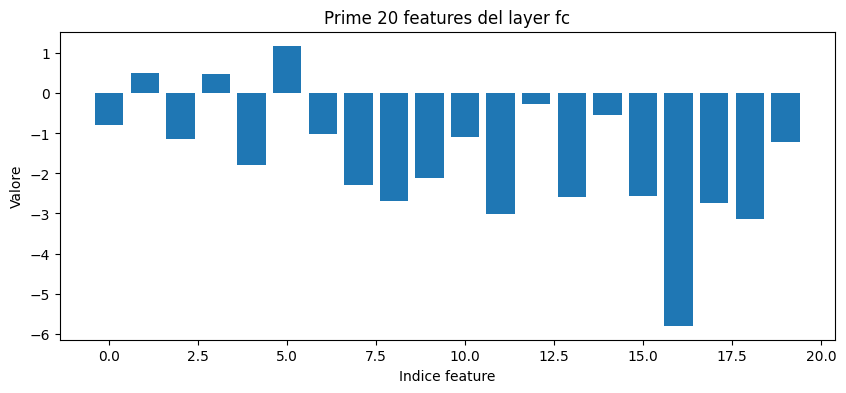

In [3]:
import torch
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
import matplotlib.pyplot as plt

def extract_resnet_fc_features(img_path):
    # Carica l'immagine e assicura la modalità RGB
    img = Image.open(img_path).convert('RGB')
    
    # Pre-processamento standard per ResNet: ridimensiona, ritaglia, trasforma in tensor e normalizza
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])
    img_tensor = preprocess(img).unsqueeze(0)  # Aggiungi la dimensione del batch
    
    # Carica la ResNet50 pre-addestrata e mettila in modalità eval
    resnet = models.resnet50(pretrained=True)
    resnet.eval()
    
    # Lista per salvare l'output del layer fc
    fc_output = []

    # Definisci un hook che memorizza l'output del layer fc
    def hook_fn(module, input, output):
        fc_output.append(output)
    
    # Registra il forward hook sul layer fully connected
    hook = resnet.fc.register_forward_hook(hook_fn)
    
    # Passa l'immagine attraverso il modello
    with torch.no_grad():
        resnet(img_tensor)
    
    # Rimuovi l'hook (è buona norma pulirlo dopo l'uso)
    hook.remove()
    
    # Il risultato è salvato in fc_output[0] con shape [1, 1000]. Rimuovi la dimensione del batch:
    features = fc_output[0].squeeze(0)
    
    # Stampa e visualizza il vettore delle features
    print("Vettore delle features (1000 elementi):")
    print(features.numpy())
    
    # Visualizzazione opzionale: ad esempio, un bar plot dei primi 20 valori
    plt.figure(figsize=(10, 4))
    plt.bar(range(20), features.numpy()[:20])
    plt.xlabel("Indice feature")
    plt.ylabel("Valore")
    plt.title("Prime 20 features del layer fc")
    plt.show()
    
    return features

# Esempio di esecuzione
img_path = "Part1/brain_glioma/brain_glioma_0002.jpg"  # Sostituisci con il percorso corretto della tua immagine
features = extract_resnet_fc_features(img_path)


Task: 2

In [4]:
import os
import csv
import torch
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image

def extract_fc_features_from_image(image_path, model, preprocess, device):
    """
    Apre l'immagine, la pre-processa e la passa attraverso la rete.
    Utilizza un hook per catturare l'output del layer fully connected (fc) della ResNet.
    Restituisce un vettore numpy di dimensione 1000.
    """
    try:
        img = Image.open(image_path).convert("RGB")
    except Exception as e:
        print(f"Errore nell'apertura dell'immagine {image_path}: {e}")
        return None

    img_tensor = preprocess(img).unsqueeze(0).to(device)
    
    fc_output = []

    # Definizione del hook per catturare l'output del layer fc
    def hook_fn(module, input, output):
        fc_output.append(output)

    hook = model.fc.register_forward_hook(hook_fn)
    with torch.no_grad():
        model(img_tensor)
    hook.remove()

    # fc_output[0] ha forma [1, 1000], rimuoviamo la dimensione batch e riportiamo su CPU
    features = fc_output[0].squeeze(0).cpu().numpy()
    return features

def main():
    # Imposta il percorso della cartella base e le sottocartelle
    base_dir = "Part1"
    subfolders = ["brain_glioma", "brain_menin", "brain_tumor"]
    image_extensions = (".jpg", ".jpeg", ".png", ".bmp")

    image_paths = []
    # Cerca le immagini all'interno delle sottocartelle specificate
    for sub in subfolders:
        dir_path = os.path.join(base_dir, sub)
        if os.path.isdir(dir_path):
            for root, _, files in os.walk(dir_path):
                for file in files:
                    if file.lower().endswith(image_extensions):
                        image_paths.append(os.path.join(root, file))
        else:
            print(f"La cartella {dir_path} non esiste.")

    if not image_paths:
        print("Non sono state trovate immagini nelle cartelle specificate.")
        return

    # Configura il dispositivo da utilizzare (GPU se disponibile, altrimenti CPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Definisci la trasformazione di pre-processing standard per ResNet
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])

    # Carica il modello ResNet50 pre-addestrato ed impostalo in modalità evaluation
    model = models.resnet50(pretrained=True)
    model.eval()
    model.to(device)

    # Prepara i dati che verranno salvati sul file CSV
    csv_rows = []
    # Crea l'header: la prima colonna è il percorso dell'immagine, le altre sono le feature
    header = ["image_path"] + [f"fc_feature_{i}" for i in range(1000)]
    csv_rows.append(header)

    # Estrai le features per ogni immagine e conserva il risultato in una riga di CSV
    for img_path in image_paths:
        features = extract_fc_features_from_image(img_path, model, preprocess, device)
        if features is not None:
            row = [img_path] + features.tolist()
            csv_rows.append(row)
        else:
            print(f"Errore nell'estrazione delle features da {img_path}")

    # Salva i risultati in un file CSV
    csv_file = "resnetfc.csv"
    try:
        with open(csv_file, "w", newline="") as f:
            writer = csv.writer(f)
            writer.writerows(csv_rows)
        print(f"Salvataggio completato in {csv_file}")
    except Exception as e:
        print(f"Errore durante il salvataggio del file CSV: {e}")

if __name__ == "__main__":
    main()


Salvataggio completato in resnetfc.csv
